# Visualizing Body Data
To better capture soft-tissue dynamics, SMPL offers a shape dependent model of
dynamic deformations adapted from the  Dyna model [Pons-Moll et al. 2015].
We call dynamic blend shapes as DMPL. DMPL is obtained by applying PCA on vertex errors between
SMPL and Dyna training meshes, transformed into the rest pose.
Animating soft-tissue dynamics in a standard rendering engine simply requires using the dynamic linear
blend shape coefficients similar to any other time-dependent parameters of SMPL, e.g. pose and global translation.
AMASS uses 8 DMPL parameters to extract soft-tissue motions realistically from a sparse set of markers.

DMPLs are most visible for rapid motions on fatty tissue.

Bellow we visualize a sequence form AMASS with and without DMPL parameters

In [1]:
# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:
import torch
import numpy as np

from human_body_prior.tools.omni_tools import copy2cpu as c2c
from os import path as osp

support_dir = '../support_data/'

In [3]:
# Choose the device to run the body model on.
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We assume you have downloaded the required body model and placed them in body_models directory of this repository.
For SMPL+H body model, download it from http://mano.is.tue.mpg.de/.
Please download the AMASS version of the model with DMPL blendshapes.
You can obtain dynamic shape blendshapes, e.g. DMPLs, from http://smpl.is.tue.mpg.de.
If you use any of these models in your research please follow their respective citation rules.

In [4]:
amass_npz_fname = osp.join(support_dir, 'github_data/dmpl_sample.npz') # the path to body data
bdata = np.load(amass_npz_fname)

# you can set the gender manually and if it differs from data's then contact or 
# interpenetration issues might happen
subject_gender = (bdata['gender'].tolist()).decode()

print('Data keys available:%s'%list(bdata.keys()))

print('The subject of the mocap sequence is  {}.'.format(subject_gender))

Data keys available:['poses', 'gender', 'mocap_framerate', 'betas', 'marker_data', 'dmpls', 'marker_labels', 'trans']
The subject of the mocap sequence is  female.


In [5]:
from human_body_prior.body_model.body_model import BodyModel

bm_fname = osp.join(support_dir, 'body_models/smplh/female/model.npz'.format(subject_gender))
dmpl_fname = osp.join(support_dir, 'body_models/dmpls/female/model.npz'.format(subject_gender))

num_betas = 16 # number of body parameters
num_dmpls = 8 # number of DMPL parameters

bm = BodyModel(bm_fname=bm_fname, num_betas=num_betas, num_dmpls=num_dmpls, dmpl_fname=dmpl_fname).to(comp_device)
faces = c2c(bm.f)


The provided sample data has the original mocap marker data.
In the following we make PyTorch tensors for parameters controlling different part of the body model.

In [6]:
time_length = len(bdata['trans'])

body_parms = {
    'root_orient': torch.Tensor(bdata['poses'][:, :3]).to(comp_device), # controls the global root orientation
    'pose_body': torch.Tensor(bdata['poses'][:, 3:66]).to(comp_device), # controls the body
    'pose_hand': torch.Tensor(bdata['poses'][:, 66:]).to(comp_device), # controls the finger articulation
    'trans': torch.Tensor(bdata['trans']).to(comp_device), # controls the global body position
    'betas': torch.Tensor(np.repeat(bdata['betas'][:num_betas][np.newaxis], repeats=time_length, axis=0)).to(comp_device), # controls the body shape. Body shape is static
    'dmpls': torch.Tensor(bdata['dmpls'][:, :num_dmpls]).to(comp_device) # controls soft tissue dynamics
}

print('Body parameter vector shapes: \n{}'.format(' \n'.join(['{}: {}'.format(k,v.shape) for k,v in body_parms.items()])))
print('time_length = {}'.format(time_length))

Body parameter vector shapes: 
root_orient: torch.Size([235, 3]) 
pose_body: torch.Size([235, 63]) 
pose_hand: torch.Size([235, 90]) 
trans: torch.Size([235, 3]) 
betas: torch.Size([235, 16]) 
dmpls: torch.Size([235, 8])
time_length = 235


Import the required files for viewing out mesh:

In [7]:
import trimesh
from body_visualizer.tools.vis_tools import colors
from body_visualizer.mesh.mesh_viewer import MeshViewer
from body_visualizer.mesh.sphere import points_to_spheres
from body_visualizer.tools.vis_tools import show_image
from body_visualizer.tools.vis_tools import imagearray2file

imw, imh=1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

### Visualize DMPLs

You can control the soft tissue dynamics with DMPL parameters.
Please have in mind, to better visualize DMPLs you would need to render a sequence.
Refer to full renders of the parameter sequences in our [website](https://amass.is.tue.mpg.de/).

Below we add an offset value to body with and withou DMPL paramters for visualization.

Body on the left is with DMPLs and on the right without.

[gahyeon]: If you met "The keyword `fps` is no longer supported. Use `duration`" during running the next code block, please try to change the keyword to duration instead of fps and modify its value `len(img_array)/fps` instead of fps.   
[gahyeon]: I'm not sure it is the appropriate way... but let me know if you find the better way ㅠㅠ...

before:
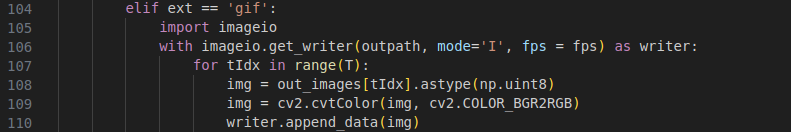

after:
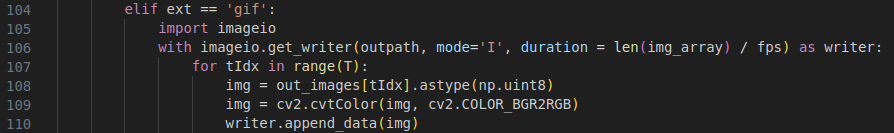

In [14]:
w_dmpl_parms = {k:v for k,v in body_parms.items() if k in ['pose_body', 'betas', 'pose_hand', 'dmpls']}
w_dmpl_trans = torch.zeros_like(body_parms['trans'])
w_dmpl_trans[:,0] += -0.5
w_dmpl_parms['trans'] = w_dmpl_trans
body_dmpls = bm(**w_dmpl_parms)

wo_dmpl_parms = {k:v for k,v in body_parms.items() if k in ['pose_body', 'betas', 'pose_hand']}
wo_dmpl_trans = torch.zeros_like(body_parms['trans'])
wo_dmpl_trans[:,0] += 0.5
wo_dmpl_parms['trans'] = wo_dmpl_trans
body_wo_dmpls = bm(**wo_dmpl_parms)

def vis_dmpl_comparision():
    image_arr = []
    for fId in range(time_length):
        body_mesh_w_dmpl = trimesh.Trimesh(vertices=c2c(body_dmpls.v[fId]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
        body_mesh_wo_dmpl = trimesh.Trimesh(vertices=c2c(body_wo_dmpls.v[fId]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
    
        mv.set_static_meshes([body_mesh_w_dmpl, body_mesh_wo_dmpl])
        body_image = mv.render(render_wireframe=False)
        image_arr.append(body_image)

    image_arr = np.array(image_arr).reshape([1,1,-1, 1600, 1600, 3])
    imagearray2file(image_arr, outpath='./dmpl_sample.gif', fps=60)
    imagearray2file(image_arr, outpath='./dmpl_sample.mp4', fps=60)

    
vis_dmpl_comparision()

<img src="dmpl_sample.gif" width="750" align="center">